In [115]:
import tensorflow as tf

In [116]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [117]:
import pandas as pd
time_data = pd.read_csv(r'../Dataset/2nd_Wave_Dataset.csv', header=None)

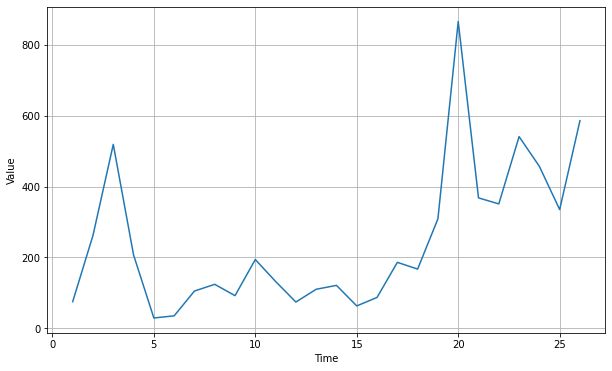

In [118]:
import csv
time_step = []
covid = []
step = 1

with open(r'../Dataset/2nd_Wave_dataset.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        covid.append(float(row[1]))
        time_step.append(step)
        step += 1
        
series = np.array(covid)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [119]:
len(series)

26

In [120]:
w1 = 1,2,3,4,5
w2 = 2,3,4,5,6

In [121]:
split_time = 22
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 3 ##changed from 22 to 3
shuffle_buffer_size = 20

In [122]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [123]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [124]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = window_size
batch_size = batch_size
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  #tf.keras.layers.Conv1D(filters=10, kernel_size=3, strides=1, padding="same", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20, return_sequences=True)),
  tf.keras.layers.Dense(5, activation="tanh"),
  tf.keras.layers.Dropout(0),
  #tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.78)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(22,)
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [==============================] - 0s 5ms/step - loss: 122.2174 - mae: 122.7174
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 122.2039 - mae: 122.7039
Epoch 3/100
1/1 [==============================] - 0s 949us/step - loss: 122.1783 - mae: 122.6783
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 122.1413 - mae: 122.6413
Epoch 5/100
1/1 [=====

1/1 [==============================] - 0s 879us/step - loss: 122.6278 - mae: 123.1278
Epoch 77/100
1/1 [==============================] - 0s 887us/step - loss: 132.2209 - mae: 132.7209
Epoch 78/100
1/1 [==============================] - 0s 919us/step - loss: 123.1170 - mae: 123.6170
Epoch 79/100
1/1 [==============================] - 0s 911us/step - loss: 121.8959 - mae: 122.3959
Epoch 80/100
1/1 [==============================] - 0s 908us/step - loss: 120.4509 - mae: 120.9509
Epoch 81/100
1/1 [==============================] - 0s 986us/step - loss: 124.5743 - mae: 125.0743
Epoch 82/100
1/1 [==============================] - 0s 1ms/step - loss: 122.6299 - mae: 123.1299
Epoch 83/100
1/1 [==============================] - 0s 893us/step - loss: 119.6966 - mae: 120.1966
Epoch 84/100
1/1 [==============================] - 0s 1ms/step - loss: 119.4198 - mae: 119.9198
Epoch 85/100
1/1 [==============================] - 0s 837us/step - loss: 119.2461 - mae: 119.7461
Epoch 86/100
1/1 [=========

(1e-08, 0.0001, 0.0, 1000.0)

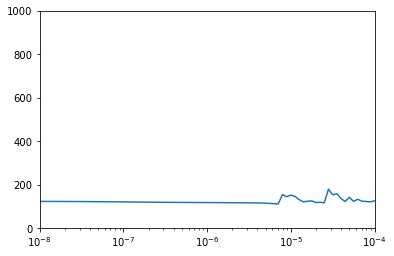

In [125]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 1000])

In [126]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

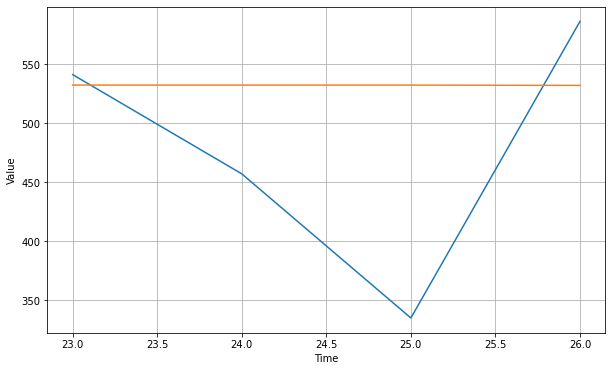

In [127]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [128]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

83.809326

In [129]:
print(rnn_forecast)

[532.13806 532.13806 532.1277  531.8904 ]


In [130]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 40)          2760      
_________________________________________________________________
dense (Dense)                (None, None, 5)           205       
_________________________________________________________________
dropout (Dropout)            (None, None, 5)           0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           6         
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 2,971
Trainable params: 2,971
Non-trainable params: 0
_________________________________________________________________
